# `xarray` and `ICON`

In [1]:
import xarray as xr
xr.set_options(display_style='text')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
import cartopy as cp

> on mistral `compute2`

In [2]:
# ICON output I want to work with
ds = xr.open_dataset('/work/mh0033/m211054/projects/icon/icon-oes-1.3.01/experiments/exp.ocean_era51h_r2b8_hel20218-ERA/outdata/exp.ocean_era51h_r2b8_hel20218-ERA_19970401T000000Z.nc',
                     chunks={'depth': 1})

In [3]:
#!ls /work/mh0033/m211054/projects/icon/icon-oes-1.3.01/experiments/exp.ocean_era51h_r2b8_hel20218-ERA/outdata/

In [4]:
ds.nbytes/1e9,'GB'

(45.630967468, 'GB')

In [5]:
#ds.data_vars

In [6]:
v='to'

In [7]:
def rad_to_deg(ds):
    """Convert radian units to deg."""
    #ds.coords.compute()
    with xr.set_options(keep_attrs=True):
        for c in ds.coords:
            if 'units' in ds[c].attrs:
                if ds[c].attrs['units'] == 'radian':
                    print(f'convert {c} from rad to deg')
                    ds[c] = ds[c]* 180./np.pi
                    ds[c].attrs['units'] = 'degrees'
            elif 'bnds' in c:
                print(f'convert {c} from rad to deg')
                ds[c] = ds[c]* 180./np.pi
                ds[c].attrs['units'] = 'degrees'
    return ds

In [8]:
ds = ds.set_coords(['clon_bnds','clat_bnds'])

ds = rad_to_deg(ds)

convert clon from rad to deg
convert clon_bnds from rad to deg
convert clat from rad to deg
convert clat_bnds from rad to deg
convert elon from rad to deg
convert elat from rad to deg


# `xoak`

- https://xoak.readthedocs.io/en/latest/examples/introduction.html
- https://xoak.readthedocs.io/en/latest/examples/dask_support.html

In [6]:
import xoak

In [8]:
#igrid = xr.open_dataset('/work/mh0727/m300732/icon-oes-hamocc/experiments/ler0956/icon_grid_0036_R02B04_O.nc')
#igrid = rad_to_deg(igrid)

In [16]:
#try https://cf-xarray.readthedocs.io/en/latest/examples/introduction.html
#import cf_xarray as cfxr
#ds[v].attrs['coordinates'] = 'clon clat clon_bnds clat_bnds'
#ds[v].attrs['ancillary_variables'] = 'clon clat clon_bnds clat_bnds'
#ds.cf[v]

In [17]:
ds.to.nbytes/1e6,'MB'

(1909.248512, 'MB')

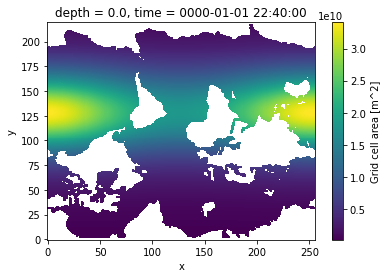

In [18]:
# new grid I want to work on
new_grid = xr.open_dataset('/work/mh0727/m300524/masks/GR15L40_fx.nc')
new_grid.area.plot()
#new_grid = xr.open_dataset('/work/mh0727/m300524/masks/GE_echam_grid.nc')
#new_grid.cell_area.plot()

## remap with xoak

In [19]:
# set xoak index
%time ds.xoak.set_index(['clat', 'clon'], 'sklearn_geo_balltree')

CPU times: user 8.06 s, sys: 116 ms, total: 8.18 s
Wall time: 8.12 s


In [15]:
%%time
from dask.diagnostics import ProgressBar
import dask
with ProgressBar(), dask.config.set(scheduler='processes'):
    ds_selection = ds.xoak.sel(clat=new_grid.lat, clon=new_grid.lon)

# %time ds_selection = ds.xoak.sel(clat=new_grid.lat, clon=new_grid.lon) # also runs without dask scheduler
print('remapping',ds.nbytes/1e6,'MB  to ',ds_selection.nbytes/1e6,'MB','lazily')

[########################################] | 100% Completed | 21.8s
remapping 45630.967468 MB  to  20788.953184 MB lazily
CPU times: user 3min 44s, sys: 2.35 s, total: 3min 47s
Wall time: 4min 7s


In [ ]:
%time ds_selection.mean(['x','y'])

In [ ]:
# all lazy dask arrays
ds_selection['to'] # ncells is no dimension anymore, but x and y, or lon and lat

## plot remapped with `xarray.plot()`

CPU times: user 2.12 s, sys: 3.88 s, total: 6.01 s
Wall time: 1.11 s


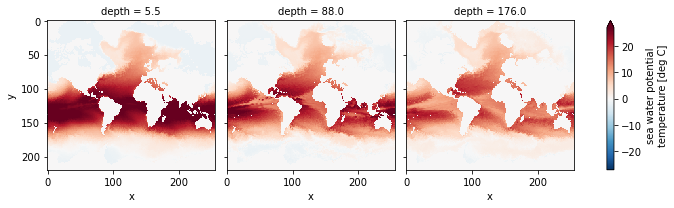

In [17]:
%time ds_selection['to'].isel(depth=[0,10,20]).plot(col='depth', robust=True, yincrease=False)

## plot remapped with `pymistral.plot()` wrapping xarray and cartopy

CPU times: user 4.01 s, sys: 4.08 s, total: 8.09 s
Wall time: 2.82 s


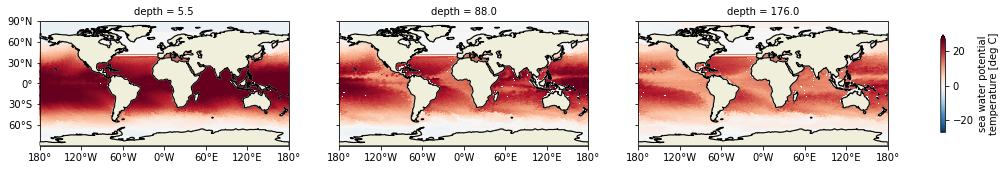

In [18]:
import pymistral
%time ds_selection[v].isel(depth=[0,10,20]).squeeze().rename({'clon':'lon','clat':'lat'}).compute().plot_map(col='depth',robust=True, aspect=2, feature='land')

# Triangular plotting

plotting the triangles with `plt.tripcolor` from `xarray`

In [15]:
import pymistral # instantiates/allows to call ds.icon.plot()

In [16]:
ds[v].sizes

Frozen({'time': 1, 'depth': 128, 'ncells': 3729001})

convert clon from rad to deg
convert clon_bnds from rad to deg
convert clat from rad to deg
convert clat_bnds from rad to deg
convert elon from rad to deg
convert elat from rad to deg


<GeoAxesSubplot:title={'center':' depth = 5.5, time = 1997-04-01'}>

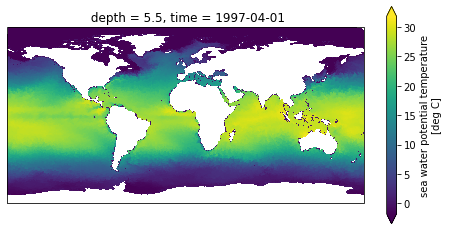

In [17]:
ds.isel(depth=0,time=0).icon.plot(v)

### same code in notebook for quick dev

In [20]:
@xr.register_dataset_accessor('icon')
class CartopyMap(object):
    def __init__(self, xarray_obj):
        self._obj = xarray_obj

    def plot(self,
             v=None,
             ax=None,
             proj=ccrs.PlateCarree(),
             robust=False,
             feature=None,
             mask=True,
             lon='clon',
             lat='clat',
             lon_bnds='clon_bnds',
             lat_bnds='clat_bnds',
             **tripcolor_kwargs
        ):
        """
        Plot the variable v from an xr.Dataset.
        
        Note: xr.DataArray.icon.plot() would be nicer,
        but the xr.DataArray doesnt carry the neccessary clon_bnds and clat_bnds coords.
        
        Ideally, this plot function could work like xr.DataArray.plot(col, row, ...)
        """
        da = self._obj
        
        # --- Triangulation
        ntr = da[lon].size
        clon_bnds_rs = da[lon_bnds].values.reshape(ntr*3)
        clat_bnds_rs = da[lat_bnds].values.reshape(ntr*3)
        triangles = np.arange(ntr*3).reshape(ntr,3)
        Tri = matplotlib.tri.Triangulation(clon_bnds_rs, clat_bnds_rs, triangles=triangles)
        if mask: # mask big triangles https://gitlab.dkrz.de/m300602/pyicon/-/blob/master/pyicon/pyicon_tb.py#L966
            mask_bt = (
      (np.abs(  clon_bnds_rs[triangles[:,0]] 
              - clon_bnds_rs[triangles[:,1]])>180.)
    | (np.abs(  clon_bnds_rs[triangles[:,0]] 
              - clon_bnds_rs[triangles[:,2]])>180.)
                )
            Tri.set_mask(mask_bt)


        if isinstance(da,xr.Dataset):
            if v is None:
                v=list(da.data_vars)
                if len(v)>0:
                    v=v[0] # take first variable
                    da=da[v]
            else:
                da=da[v]

        vmin = tripcolor_kwargs.pop('vmin',None)
        vmax = tripcolor_kwargs.pop('vmax',None)
        if vmin is None and vmax is None and robust:
            vmin = da.quantile(0.02).values
            vmax = da.quantile(.98).values
        
        # what if more than two dims: see xr.facetgrid
        fig, axes = plt.subplots(subplot_kw=dict(projection=proj) if proj else None,figsize=(8,4))
        # best would be to add tripcolor to xarray
        tripcolor_kwargs.update({'vmin':vmin, 'vmax':vmax})
        if proj:
            tripcolor_kwargs.update({'transform':ccrs.PlateCarree()})
        hm = axes.tripcolor(Tri,
                            da,
                            **tripcolor_kwargs
                            )
        # now add features, labels etc
        if feature and proj:
            axes.add_feature(cp.feature.LAND, zorder=0)
        #axes.set_extent((-178, 178, -88, 88), crs=ccrs.PlateCarree())
        cb = plt.colorbar(mappable=hm, ax=axes, extend='both')
        ## use metadata
        title_str = ''
        title_labels = [c for c in da.coords if da.coords[c].size == 1]
        for l in title_labels:
            title_str += f', {l} = {str(da[l].astype(str).values)}'
        axes.set_title(title_str[1:].replace("T00:00:00.000000000",""))
        cb.set_label(f'{da.attrs["long_name"]}\n[{da.attrs["units"]}]', rotation = 90)
        # add x,y ticks and labels
        return axes

CPU times: user 58.8 s, sys: 1.49 s, total: 1min
Wall time: 1min


<GeoAxesSubplot:title={'center':' depth = 5.5, time = 1997-04-01'}>

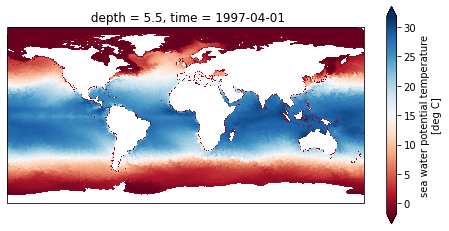

In [21]:
%time ds.isel(depth=0,time=0).icon.plot(v, cmap='RdBu')

CPU times: user 19.5 s, sys: 1.42 s, total: 20.9 s
Wall time: 20.8 s


<AxesSubplot:title={'center':' depth = 5.5, time = 1997-04-01'}>

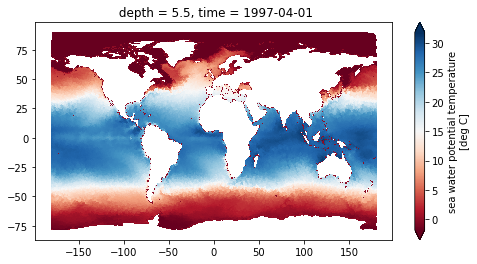

In [22]:
# without cartopy
%time ds.isel(depth=0,time=0).icon.plot(v, cmap='RdBu', proj=False)

CPU times: user 23.8 s, sys: 647 ms, total: 24.4 s
Wall time: 24.4 s


<GeoAxesSubplot:title={'center':' depth = 176.0, time = 1997-04-01'}>

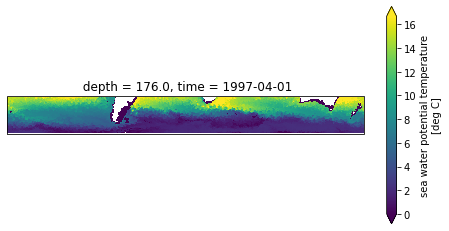

In [16]:
# subselect spatially: Southern Ocean
ds_SO = ds.isel(depth=20,time=0).where((ds.clat < -30) & (ds.clat > -65),drop=True)
%time ds_SO.icon.plot(v, robust=True, feature=None)

CPU times: user 8.4 s, sys: 624 ms, total: 9.03 s
Wall time: 8.94 s


<AxesSubplot:title={'center':' depth = 176.0, time = 1997-04-01'}>

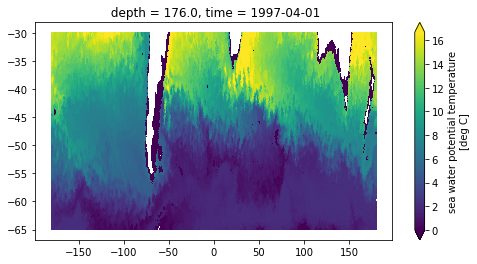

In [17]:
#plot without cartopy
%time ds_SO.icon.plot(v, robust=True, proj=None)

In [27]:
ds_small = ds.isel(depth=20,time=0).where((ds.clat < -45) & (ds.clat > -65) & (ds.clon > -80) & (ds.clon < -50),drop=True)

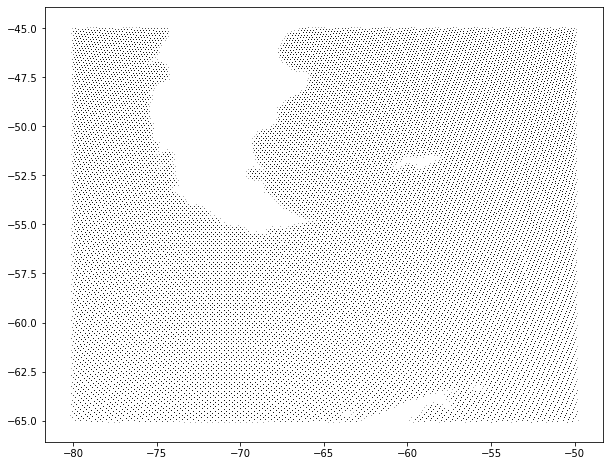

In [28]:
fig,ax = plt.subplots(figsize=(10,8))
ax.scatter(ds_small.clon_bnds, ds_small.clat_bnds, c='k', marker='.', s=1, linewidth=0.1)

In [29]:
import matplotlib
def tri(ds_small):
    ntr = ds_small.clon.size
    clon_bnds_rs = ds_small['clon_bnds'].values.reshape(ntr*3)
    clat_bnds_rs = ds_small['clat_bnds'].values.reshape(ntr*3)
    triangles = np.arange(ntr*3).reshape(ntr,3)
    Tri = matplotlib.tri.Triangulation(clon_bnds_rs, clat_bnds_rs, triangles=triangles)
    return Tri

In [30]:
%time _ = tri(ds_small)

CPU times: user 632 ms, sys: 157 ms, total: 789 ms
Wall time: 784 ms


In [31]:
# triangulation itself is not slow, its the plotting I guess
%time _ = tri(ds)

CPU times: user 801 ms, sys: 266 ms, total: 1.07 s
Wall time: 1.06 s


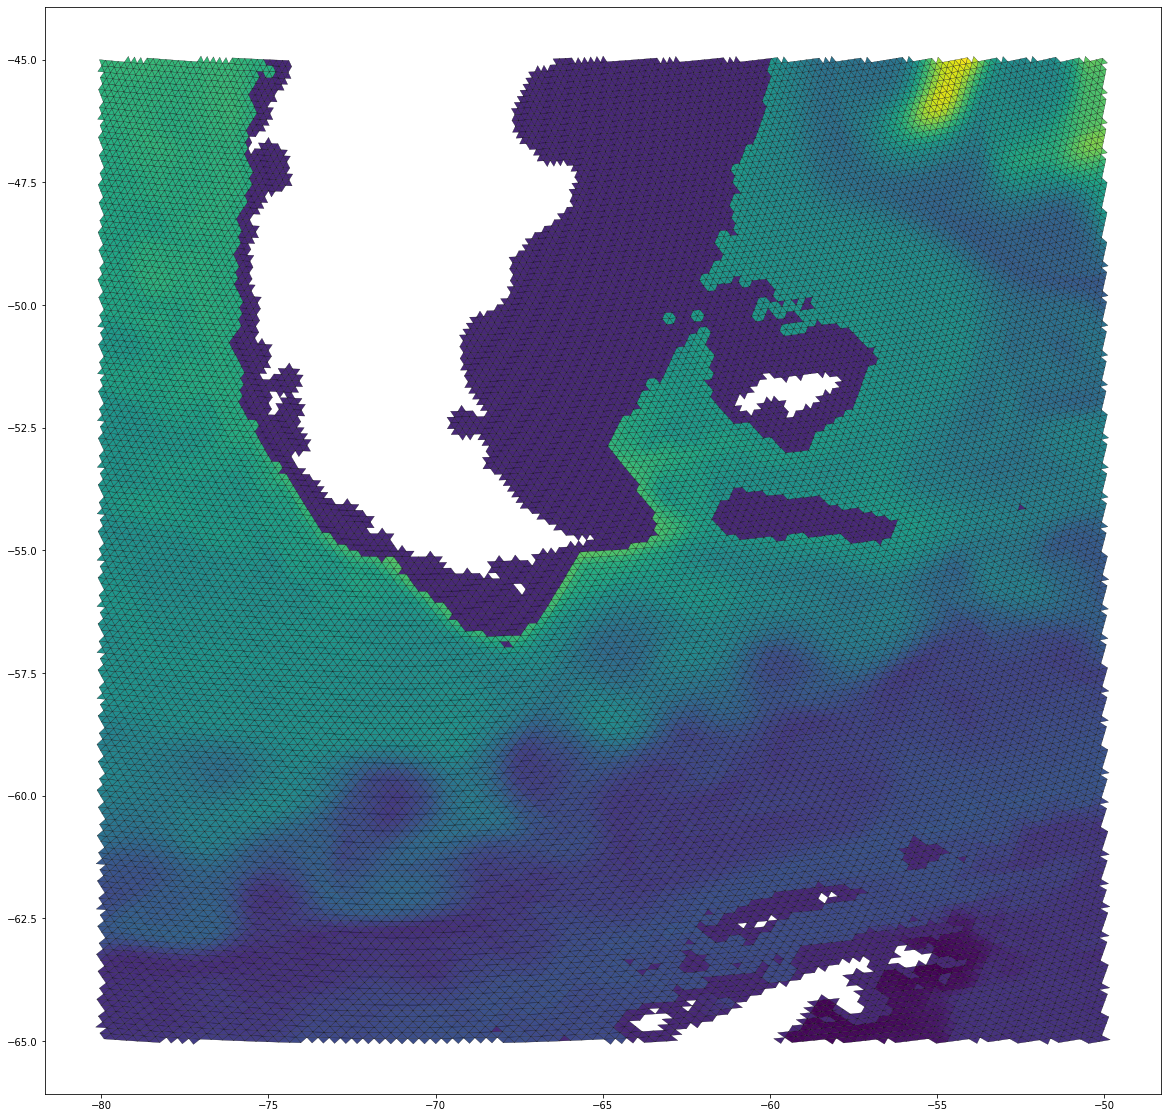

In [32]:
fig,ax = plt.subplots(figsize=(20,20))
ax.tripcolor(tri(ds_small), ds_small[v], edgecolors='k')

CPU times: user 1.56 s, sys: 235 ms, total: 1.79 s
Wall time: 1.74 s


<GeoAxesSubplot:title={'center':' depth = 176.0, time = 1997-04-01'}>

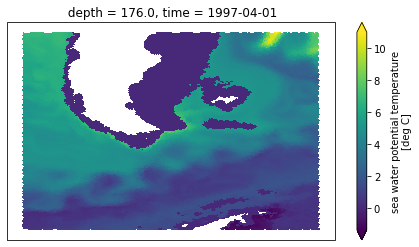

In [38]:
%time ds_small.icon.plot(v, feature=False)

CPU times: user 1.11 s, sys: 249 ms, total: 1.36 s
Wall time: 1.31 s


<AxesSubplot:title={'center':' depth = 176.0, time = 1997-04-01'}>

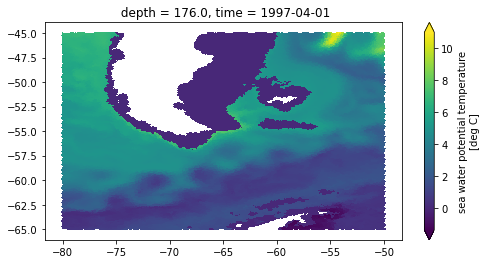

In [39]:
%time ds_small.icon.plot(v, proj=None)

# plot with `datashader`

In [9]:
# https://examples.pyviz.org/bay_trimesh/bay_trimesh.html
# https://datashader.org/user_guide/Trimesh.html#parallelizing-trimesh-aggregation-with-dask

In [ ]:
# does not plot triangles, but triangulates first and then grids onto reg lon, lat grid

In [10]:
import datashader, datashader.transfer_functions as tf, datashader.utils as du

In [11]:
da = ds[v].isel(time=0, depth=0)

In [12]:
verts = da.to_dataframe()[['clon','clat',v]]
verts

clon       clat         to
ncells                                  
0        73.000000  72.131378  -1.799998
1        73.233093  72.177437  -1.800001
2        72.766899  72.177437  -1.799997
3        73.000000  72.067368  -1.800000
4        73.463425  72.066925  -1.800004
...            ...        ...        ...
3728996  76.220886 -45.340641  11.541810
3728997  76.396477 -45.178043  11.721661
3728998  76.306747 -45.216522  11.686987
3728999  76.392151 -45.092308  11.731946
3729000  76.495514 -45.211773  11.761610

[3729001 rows x 3 columns]

In [13]:
import numpy as np
import pandas as pd
import datashader.utils as du, datashader.transfer_functions as tf
from scipy.spatial import Delaunay
import dask.dataframe as dd

In [14]:
def triangulate(vertices, x="x", y="y"):
    """
    Generate a triangular mesh for the given x,y,z vertices, using Delaunay triangulation.
    For large n, typically results in about double the number of triangles as vertices.
    """
    triang = Delaunay(vertices[[x,y]].values)
    print('Given', len(vertices), "vertices, created", len(triang.simplices), 'triangles.')
    return pd.DataFrame(triang.simplices, columns=['v0', 'v1', 'v2'])

In [15]:
# only needs to be done once: takes longest now, could be saved
%time tris = triangulate(verts, x='clon',y='clat')

Given 3729001 vertices, created 7457907 triangles.
CPU times: user 34 s, sys: 1.29 s, total: 35.3 s
Wall time: 35.3 s


In [56]:
tris.head()

v0       v1       v2
0  3435748  3642567  2987009
1  3356098   177289    91509
2    92063    92098    92099
3    92036    92038    91509
4    92038    92039    91509

In [43]:
%%time
# use dask to parallelize aggregate
if True:
    tris_ddf = dd.from_pandas(tris, npartitions=8)
    verts_ddf = dd.from_pandas(verts, npartitions=8)

    mesh_ddf = du.mesh(verts_ddf, tris_ddf)
else:
    mesh_ddf = None

CPU times: user 1.21 s, sys: 464 ms, total: 1.68 s
Wall time: 1.67 s


In [44]:
deg = 0.25 # degree resolution of the final xarray

In [45]:
%time cvs = datashader.Canvas(int(360*(1/deg)), int(180*(1/deg)))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 22.2 µs


In [46]:
%time x = cvs.trimesh(verts, tris, interp='nearest', mesh=mesh_ddf)

CPU times: user 2.46 s, sys: 1.28 s, total: 3.74 s
Wall time: 3.57 s


In [47]:
x.nbytes/1e6,'MB'

(8.2944, 'MB')

In [48]:
x.sizes

Frozen({'clat': 720, 'clon': 1440})

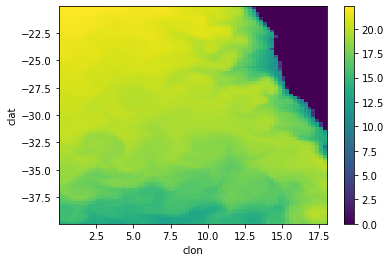

In [65]:
# zoom aghulas
x.sel(clon=slice(0,18), clat=slice(-40,-20)).plot()

CPU times: user 125 ms, sys: 14 ms, total: 139 ms
Wall time: 134 ms


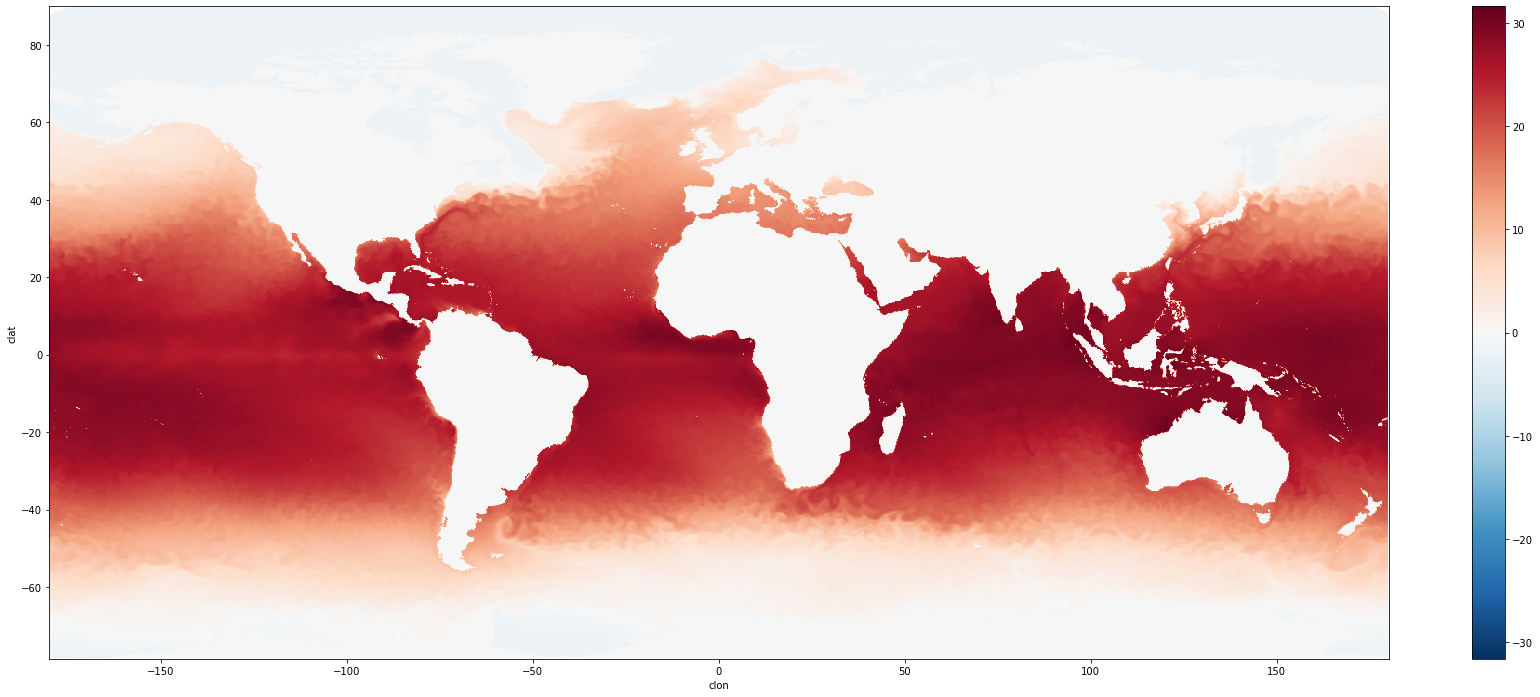

In [50]:
%time x.plot(figsize=(30,12))